# Academy Practicum 1

## Stellar properties, metallicity, and Galactic context of planet formation

---

### MOTIVATION

#### Understanding Radial Structure and Migration in the Milky Way Disk

The Milky Way is not a static system.
Stars are born at different galactocentric radii, migrate over time, and interact with large-scale structures such as spiral density waves. As a result, the present-day distribution of stars in the Galactic disk carries the imprint of both where stars formed and how they have moved since their birth.

In recent years, large spectroscopic and astrometric surveys (e.g. `APOGEE`, `Gaia`) have made it possible to study the Milky Way disk with unprecedented detail. However, interpreting these data requires a clear conceptual framework that connects:
- observed stellar properties (metallicity, age proxies, spatial distribution),
- Galactic dynamics (rotation, radial migration),
- and large-scale disk structure (inside-out formation, spiral arms, density waves).

This practical notebook accompanies the article [@teixeira2024exoplanets] and focuses on building an intuitive, data-informed, but deliberately simplified model of the Galactic disk.
The goal is not to perform a full N-body or hydrodynamical simulation, but to construct a transparent physical picture that helps interpret observational trends and motivates more detailed models.

#### What this practicum demonstrates

In this notebook, we will:
- Construct a proxy representation of the Milky Way disk using real survey data as a statistical backbone.
- Illustrate the concept of inside-out disk formation, where star formation gradually shifts to larger radii.
- Introduce radial migration as a slow, cumulative process acting on already formed stars.
- Visualize spiral density waves as patterns that move through stellar orbits rather than rigid structures made of fixed stars.
- Show how stars enter and exit spiral arms, temporarily changing their local environment without being permanently bound to the arms.

Throughout the notebook, emphasis is placed on:
- physical intuition,
- clear assumptions,
- and visual diagnostics.


#### What this practicum is not

To avoid confusion, it is important to state explicitly what this notebook does not attempt to do:
- It is not a self-consistent gravitational simulation.
- It does not solve the Poisson equation or hydrodynamics.
- It does not aim to reproduce the Milky Way in quantitative detail.

Instead, it provides a controlled, explainable toy model, grounded in real data distributions, designed for:
- education,
- interpretation,
- and visual exploration.


#### Relation to the referenced scientific literature

This practical makes extensive use of ideas, results, and conceptual frameworks presented in the scientific articles listed in the References section. These works serve as a starting point and intellectual foundation for the exercises and visualizations presented here.

However, it is important to emphasize that this notebook does not aim to critique, challenge, or formally test the scientific conclusions of the referenced papers. We do not attempt to reproduce their analyses in full detail, nor do we engage in scientific debate regarding their specific results.

Instead, the purpose of this practical is different in nature:
- to translate key ideas from the literature into an intuitive, visual, and exploratory form;
- to encourage readers to think beyond individual studies, toward a more integrated view of Galactic evolution;
- to motivate reflection on how multiple processes — star formation, chemical enrichment, radial migration, spiral density waves — act together over time in shaping the Milky Way as a complex dynamical system.

In this sense, the practicum is intended as a conceptual synthesis and educational extension of the referenced works, rather than a commentary on their validity. It invites the reader to explore how well-established physical mechanisms may combine and interact, and how observational signatures can emerge from this evolving, multi-component system.

**This notebook is an invitation to think about the Milky Way not as a static snapshot, but as a living system evolving over cosmic time.**

---

## Part I. Observational data and stellar parameter reconstruction

In the first part of this practicum, we explore the observational stellar datasets that form the empirical foundation of our analysis. We characterize planet-hosting stars using homogeneous spectroscopic parameters and reconstruct their basic physical properties—most notably stellar ages—using standard stellar evolution models. The goal of this part is to build a consistent, physically motivated parameter set that will later be used for Galactic-scale modeling and inference.

### Data loading and initial preparation

In the first excercise, we load a pre-processed dataset derived from `APOGEE` and `Gaia` observations.
This dataset serves as a statistical proxy for the Galactic disk, rather than a one-to-one physical model of individual stars.

At this stage, we:
- Read the input catalog from disk.
- Apply basic quality cuts (e.g. valid galactocentric radius and metallicity).
- Restrict the sample to a physically meaningful radial range of the disk.
- Prepare arrays that will later be used for visualization and dynamical illustration.

**Importantly, no dynamics are applied yet.**

This step defines the initial observational backbone on top of which illustrative dynamical processes (rotation, migration, density waves) will be layered in subsequent sections.

---

### Cell 0. Notebook setup: paths and figure export

#### Purpose of this cell

This cell performs basic notebook initialization and defines a small utility that will be reused throughout the practical.
Its role is purely infrastructural: it does not perform any scientific computation or visualization yet.

Specifically, this cell:
1.	Finds the project root directory
The notebook may be executed from different subdirectories.
To make all paths robust and reproducible, we automatically walk up the directory tree until we find the folder named topics, which marks the project root.
2.	Defines the working directory for this practical
All outputs related to this practical (figures, animations, data products) are stored under
`topics/TOP_0001_exoplanet_birth_radius`.
3.	Creates a dedicated directory for exported figures
Figures generated in this notebook will be saved into a language-specific folder
(figures/en), which makes it easy to later export results to PDFs or reuse them in other products.
4.	Defines a helper function `save_fig()`
This function standardizes how figures are saved:
- consistent file format (`PNG`),
- consistent resolution (`DPI`),
- consistent layout (`bbox_inches="tight"`),
- and a single, predictable output location.

Using a helper function avoids repetitive boilerplate code and ensures that all figures
in the notebook are exported in a uniform way.

This setup allows us to focus on ideas and interpretation in later cells, without worrying about file paths or figure handling.

In [1]:
# =========================================================
# Cell 0 — Universal bootstrap (globals, paths, theme, i18n)
# Works for: ACAP_* and ANIM_*
# =========================================================

from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th

# -----------------------------
# External services (Vizier)
# -----------------------------
from astroquery.vizier import Vizier

# No row limit by default
Vizier.ROW_LIMIT = -1

from tqdm import tqdm

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ACAP_001"   # e.g. "ACAP_001", "ANIM_001"
LANG: str = "en"             # "en" / "ru"
THEME: str = "light"          # "light" / "dark"

# -----------------------------
# Animation export settings (safe to keep for ACAP too)
# -----------------------------
ANIM_FORMAT = "mp4"       # "gif" / "mp4"
FPS = 24
DPI = 200

MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"
GIF_LOOP = 0

# --- physical limits (keep consistent) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Common paths
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)

DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)

ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# --- legacy aliases (do NOT remove, used in older cells) ---
RAW  = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR

# -----------------------------
# Theme
# -----------------------------
# Use a single consistent entry point everywhere
th.apply_theme(THEME)

# -----------------------------
# Save helpers
# -----------------------------
def save_fig0(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> build artifact ID:
        ANIM_001_Figure_3
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

def anim_outpath(anim_id: str, ext: str | None = None) -> Path:
    """
    Standard output path for animations.
    Example:
        out = anim_outpath("Orbit_1")  -> ANIM_DIR/ANIM_001_Orbit_1.mp4
        out = anim_outpath("Orbit_1", ext="gif")
    """
    if ext is None:
        ext = ANIM_FORMAT
    return ANIM_DIR / f"{NOTEBOOK}_{anim_id}.{ext}"

# -----------------------------
# i18n bootstrap (force reload to avoid stale imports)
# -----------------------------
import lulab.i18n.plot_text as pt
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)

# convenience aliases (stable)
L = pt.L
T = pt.T

# -----------------------------
# Quick sanity printout
# -----------------------------
print("\n--- BOOTSTRAP ---")
print("TOPIC      :", TOPIC)
print("NOTEBOOK   :", NOTEBOOK)
print("LANG       :", LANG)
print("THEME      :", THEME)
print("TOPIC_ROOT :", TOPIC_ROOT)
print("FIG_DIR    :", FIG_DIR)
print("DATA_RAW   :", DATA_RAW_DIR)
print("DATA_PROC  :", DATA_PROCESSED_DIR)
print("ANIM_DIR   :", ANIM_DIR)
print("ANIM_FORMAT:", ANIM_FORMAT)
print("FPS / DPI  :", FPS, "/", DPI)


--- BOOTSTRAP ---
TOPIC      : TOP_0001_exoplanet_birth_radius
NOTEBOOK   : ACAP_001
LANG       : en
THEME      : light
TOPIC_ROOT : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
FIG_DIR    : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en
DATA_RAW   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw
DATA_PROC  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
ANIM_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
ANIM_FORMAT: mp4
FPS / DPI  : 24 / 200


---
### Cell 1. Distribution of host stars by effective temperature for both data samples

#### Purpose

This figure is constructed to compare the effective temperature ($T_{\mathrm{eff}}$) distributions of planet-hosting stars drawn from two independent samples: `SWEET-Cat` and `HARPS-GTO`. The goal is to assess whether both datasets probe comparable stellar populations in terms of spectral type and evolutionary stage, which is a necessary prerequisite for any meaningful comparative analysis of planetary properties and Galactic trends.

#### Data used

Data used

For both samples, we use spectroscopically derived stellar effective temperatures provided in homogeneous form within each catalogue. In the case of SWEET-Cat, only stars with consistent spectroscopic parameters $(SWFlag = 1)$ are considered. For HARPS-GTO, the temperatures are taken directly from the published stellar parameter tables, distinguishing between planet-hosting stars and stars without detected planets.

#### Method

The figure is constructed by plotting normalized histograms of $T_{\mathrm{eff}}$ for the two datasets. No evolutionary model assumptions are involved at this stage; the plot relies solely on directly observed stellar parameters. The same temperature range and binning scheme are applied to both samples to allow a direct visual comparison.


#### Code explanation

What this code does

##### 1) Imports and helper functions
The code starts by importing standard libraries for data handling (`pandas`), plotting (`matplotlib`), and online catalogue access (`astroquery.vizier`). Two small helper functions are defined:
- `canon_name()` standardizes stellar names into a canonical form, allowing robust cross-matching between different catalogues despite differences in formatting or notation.
- `pick_col()` selects the appropriate column containing host star names in the NEA table, accounting for variations in column naming between different data releases.

##### 2) Project root detection and data paths
The script automatically locates the project root directory by searching for the topics/ folder and constructs relative paths to all required data files. This avoids hard-coded absolute paths and ensures portability across different systems.

##### 3) Loading and preparing the SWEET-Cat sample (left panel)
The `SWEET-Cat` catalogue is loaded from a local CSV file. Only stars with homogeneous spectroscopic parameters `(SWFlag == 1)` are selected. The analysis is restricted to the effective temperature ($T_{eff}$) and surface gravity $(\log\;g)$, with rows containing missing or non-physical values removed. This produces a clean sample of planet-hosting stars for the left panel of the figure.

##### 4) Loading and preparing the HARPS-GTO sample from Vizier (right panel)
The `HARPS-GTO` stellar sample is retrieved directly from the Vizier service using the published catalogue identifier. As for `SWEET-Cat`, stars with missing or non-physical values of Teff and logg are excluded.

##### 5) Identifying host and single stars in HARPS-GTO
To distinguish between stars with and without detected planets in the `HARPS-GTO` sample, the `NASA Exoplanet Archive (NEA)` is used as a reference list of known planet hosts. Stellar names from HARPS-GTO are canonicalized and cross-matched against NEA host names. Stars with a match are classified as planet hosts, while the remainder are treated as single stars.

##### 6) Construction and export of Figure 1
The final figure consists of two scatter plots:
- the left panel shows `SWEET-Cat` host stars (blue points);
- the right panel shows `HARPS-GTO` stars, with single stars in green and planet-hosting stars in orange.

Both axes are inverted to follow the conventional presentation of Kiel ($log g–T_{\rm eff}$) diagrams. The figure is then saved as `Figure_1.png` using the standardized `save_fig()` helper, making it available for inclusion in other notebooks and documents.


SWEET: True
NEA  : True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_1.png


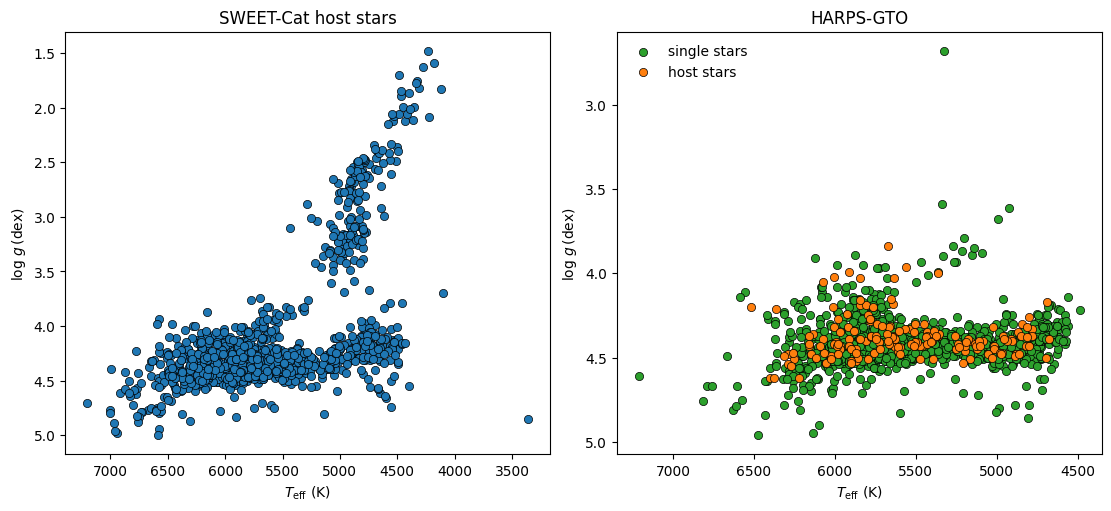

In [2]:
# =========================================================
# Cell 1 — Figure 1: HR diagram (Teff vs log g)
# =========================================================

import re
import pandas as pd
import matplotlib.pyplot as plt
from lulab.i18n.plot_text import L, T


# -------------------------------------------------
# Helpers
# -------------------------------------------------
def canon_name(x: str) -> str:
    """Canonicalize star/host names for loose matching across catalogs."""
    if pd.isna(x):
        return ""
    s = str(x).strip().lower()
    s = s.replace("–", "-").replace("—", "-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9+\- ]", "", s)
    return s.replace(" ", "")


def pick_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


# -------------------------------------------------
# Input paths (from bootstrap)
# -------------------------------------------------
sweet_path = DATA_RAW_DIR / "sweetcat.csv"
nea_path   = DATA_RAW_DIR / "nea_ps_default_flag_1.csv"

print("SWEET:", sweet_path.exists())
print("NEA  :", nea_path.exists())


# -------------------------------------------------
# SWEET-Cat (hosts only)
# -------------------------------------------------
sweet = pd.read_csv(sweet_path)
sweet_df = (
    sweet.loc[sweet["SWFlag"] == 1, ["Teff", "Logg"]]
    .dropna()
)
sweet_df = sweet_df[(sweet_df["Teff"] > 0) & (sweet_df["Logg"] > 0)]


# -------------------------------------------------
# HARPS-GTO (Vizier)
# -------------------------------------------------
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()
harps = harps.dropna(subset=["Teff", "logg"])
harps = harps[(harps["Teff"] > 0) & (harps["logg"] > 0)].copy()


# -------------------------------------------------
# NEA host list
# -------------------------------------------------
nea = pd.read_csv(nea_path)
host_col = pick_col(
    nea,
    ["hostname", "pl_hostname", "star_name", "host_name", "host", "sy_name"]
)
if host_col is None:
    raise RuntimeError("NEA host-name column not found")

nea_hosts = set(nea[host_col].dropna().map(canon_name))


# -------------------------------------------------
# Mark HARPS hosts
# -------------------------------------------------
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)

harps["is_host"] = harps["name1"].isin(nea_hosts) | harps["name2"].isin(nea_hosts)

harps_host   = harps[harps["is_host"]]
harps_single = harps[~harps["is_host"]]


# -------------------------------------------------
# Plot — Figure 1
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)

# SWEET-Cat
axes[0].scatter(
    sweet_df["Teff"], sweet_df["Logg"],
    s=35, edgecolors="k", linewidths=0.5
)
axes[0].set_title(T("figure_1_left"))
axes[0].set_xlabel(L("teff"))
axes[0].set_ylabel(L("logg"))

# Right: HARPS-GTO
axes[1].scatter(
    harps_single["Teff"], harps_single["logg"],
    s=35,
    color="tab:green",
    edgecolors="k",
    linewidths=0.5,
    label=L("legend_single_stars")
)

axes[1].scatter(
    harps_host["Teff"], harps_host["logg"],
    s=35,
    color="tab:orange",
    edgecolors="k",
    linewidths=0.5,
    label=L("legend_host_stars")
)

axes[1].set_title(T("figure_1_right"))
axes[1].set_xlabel(L("teff"))
axes[1].set_ylabel(L("logg"))
axes[1].legend(loc="upper left")

# HR / Kiel convention
for ax in axes:
    ax.invert_xaxis()
    ax.invert_yaxis()

save_fig0("Figure_1", fig=fig)
plt.show()

*Figure 1.* The $T_{eff}-\log g$ diagram for `SWEET-Cat` host stars (left panel) and for `HARPS-GTO` host and single stars (right panel).

In this cell we build Figure 1, a compact “sanity-check” view of where our target stars live in parameter space.

We plot an HR-diagram–like plane using effective temperature $T_{\rm eff}$ and surface gravity $\log g$ for two independent samples:
- *Left panel* — `SWEET-Cat`: a curated catalog of exoplanet host stars. We take only the “default/clean” subset (`SWFlag == 1`) and keep only physically valid values.
- *Right panel* — `HARPS-GTO`: a large spectroscopic sample from the HARPS Guaranteed Time Observations program (pulled from `VizieR`, catalog `J/A+A/545/A32`).

**We then split it into:**
- host stars (orange) — stars whose names match the host list from the `NASA Exoplanet Archive (NEA)`,
- single stars (green) — the rest.

**Why we do this:**
This figure visually confirms that our star samples occupy the expected regions in ($T_{\rm eff}, \log\;g$) space, and it makes clear that HARPS contains both planet hosts and non-hosts. This becomes a convenient baseline for later steps, where we compare populations and connect them to Galactic context.

**Important note (about name matching):**

The host/non-host split in `HARPS` is obtained via loose string matching of star names (after canonicalization). This is intentionally lightweight and may miss some hosts due to naming conventions and aliases. For publication-grade cross-identification we would use unique identifiers (`Gaia source IDs`, `SIMBAD IDs`, etc.), but for this practical the goal is illustrative separation, not an exact census.


### Interpretation and conclusions

The resulting distributions show that both samples are dominated by `FGK-type stars`, with effective temperatures typically ranging from approximately 4500 K to 6500 K. This reflects the well-known observational bias of radial-velocity surveys, which preferentially target slowly rotating, spectroscopically stable stars. Importantly, the substantial overlap between the two distributions indicates that `SWEET-Cat` and `HARPS-GTO` probe similar stellar populations in terms of effective temperature. This justifies their joint use in subsequent analyses and ensures that any differences observed later are unlikely to be driven by temperature-related selection effects.


---

### Cell 2. [Fe/H] distributions for SWEET-Cat host stars and HARPS-GTO stars

#### Purpose

This figure illustrates the distributions of stellar metallicity $[\mathrm{Fe/H}]$ for two independent samples: planet-hosting stars from SWEET-Cat and both host and single stars from `HARPS-GTO`. The primary goal is to examine how metallicity differs between these populations and to assess the role of chemical composition in planet occurrence.

Metallicity is a key parameter in planet formation theories, particularly in the core-accretion framework, where higher metal content in the protoplanetary disk enhances the efficiency of forming massive planetary cores. Therefore, comparing $[\mathrm{Fe/H}]$ distributions provides a direct observational link between stellar chemistry and the likelihood of hosting planets.

#### Data used

For `SWEET-Cat`, we use spectroscopically derived metallicities obtained in a homogeneous way, restricting the sample to stars with reliable parameters $(SWFlag = 1)$. For HARPS-GTO, metallicities are taken from the published stellar catalogue, with stars separated into planet hosts and stars without detected planets using cross-matching with the NASA Exoplanet Archive.

#### Method

The figure is constructed using normalized histograms of $[\mathrm{Fe/H}]$. Identical binning and metallicity ranges are applied to all subsamples to allow a direct comparison. No evolutionary models or age estimates are involved at this stage; the analysis relies purely on observed stellar abundances.

#### What the code does

##### 1) Loading and cleaning the stellar samples
The code loads metallicity measurements for `SWEET-Cat` from a local CSV file and retrieves `HARPS-GTO` metallicities from the `Vizier` catalogue. In both cases, stars with missing or non-physical $[\mathrm{Fe/H}]$ values are excluded to ensure clean and comparable samples.

##### 2) Classification of HARPS-GTO stars
Using the `NASA Exoplanet Archive` as a reference list of known planet hosts, `HARPS-GTO` stars are classified into host and single-star subsamples through name-based cross-matching. This enables a direct comparison between stars with and without detected planets within the same spectroscopic survey.

##### 3) Construction of metallicity distributions
Normalized histograms of $[\mathrm{Fe/H}]$ are computed separately for:

	- SWEET-Cat host stars,
    - HARPS-GTO host stars,
    - HARPS-GTO single stars.

The same binning and axis limits are applied to all subsamples to ensure that differences in shape and peak position reflect intrinsic population properties rather than plotting choices.

##### 4) Visualization and export
The figure is rendered as a two-panel plot: `SWEET-Cat` on the left and `HARPS-GTO` on the right. Distinct colors are used to highlight host and single-star populations. The final plot is saved as Figure_2.png using the standardized `save_fig()` function, allowing it to be reused consistently across notebooks and derived documents.

SWEET hosts: 1183
HARPS host: 170 HARPS single: 941
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_2.png


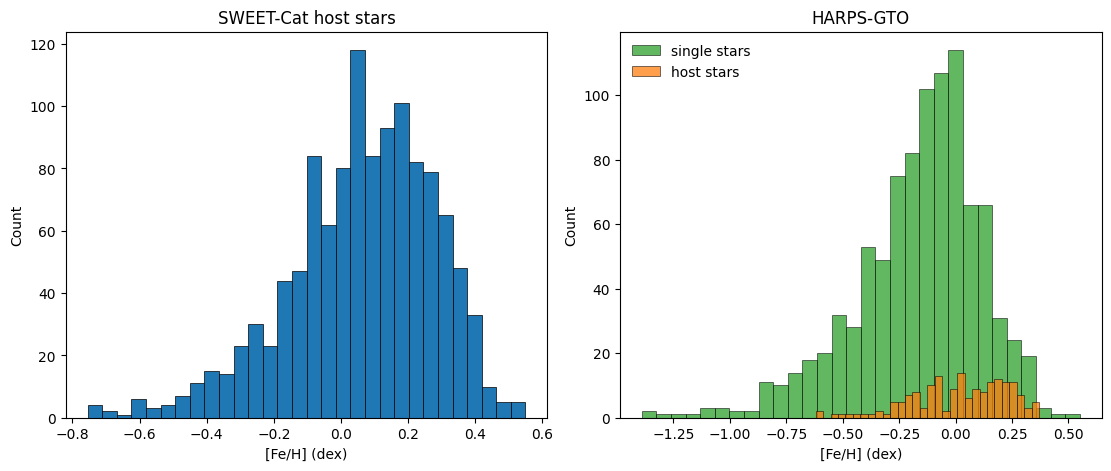

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier

from lulab.i18n.plot_text import L, T  # <-- FIX: import the aliases you use

# =========================================================
# Figure 2 — [Fe/H] distributions (SWEET-Cat vs HARPS-GTO)
# =========================================================

def canon_name(x: str) -> str:
    if pd.isna(x):
        return ""
    s = str(x).strip().lower()
    s = s.replace("–", "-").replace("—", "-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9+\- ]", "", s)
    return s.replace(" ", "")

def pick_host_col(df: pd.DataFrame) -> str:
    candidates = ["hostname", "pl_hostname", "sy_name", "star_name", "host_name", "host"]
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(
        f"NEA host-name column not found. Tried {candidates}. "
        f"Available columns: {list(df.columns)}"
    )

# --- Load SWEET-Cat + NEA (paths from bootstrap) ---
sweet_path = DATA_RAW_DIR / "sweetcat.csv"
nea_path   = DATA_RAW_DIR / "nea_ps_default_flag_1.csv"

sweet = pd.read_csv(sweet_path)
nea   = pd.read_csv(nea_path)

sweet_hosts = sweet.loc[sweet["SWFlag"] == 1, ["Teff", "Logg", "[Fe/H]"]].dropna().copy()

host_col = pick_host_col(nea)
nea_hosts = set(nea[host_col].dropna().map(canon_name).tolist())

# --- HARPS-GTO ---
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()
harps = harps.dropna(subset=["Teff", "logg", "[Fe/H]"]).copy()

harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)
harps["is_host"] = harps["name1"].isin(nea_hosts) | harps["name2"].isin(nea_hosts)

harps_host   = harps.loc[harps["is_host"]].copy()
harps_single = harps.loc[~harps["is_host"]].copy()

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4.6), constrained_layout=True)
bins = 30

axes[0].hist(sweet_hosts["[Fe/H]"], bins=bins, edgecolor="k", linewidth=0.5)
axes[0].set_title(T("figure_2_left"))
axes[0].set_xlabel(L("feh"))
axes[0].set_ylabel(L("count"))

axes[1].hist(harps_single["[Fe/H]"], bins=bins, color="tab:green",
             edgecolor="k", linewidth=0.5, alpha=0.75, label=L("legend_single_stars"))
axes[1].hist(harps_host["[Fe/H]"], bins=bins, color="tab:orange",
             edgecolor="k", linewidth=0.5, alpha=0.75, label=L("legend_host_stars"))

axes[1].set_title(T("figure_2_right"))
axes[1].set_xlabel(L("feh"))
axes[1].set_ylabel(L("count"))
axes[1].legend(loc="upper left")

print("SWEET hosts:", len(sweet_hosts))
print("HARPS host:", len(harps_host), "HARPS single:", len(harps_single))

save_fig0("Figure_2", fig=fig)
plt.show()

*Figure 2. [Fe/H] distributions for SWEET-Cat host stars (left panel) and for HARPS-GTO host and single stars (right panel).*

#### Interpretation and conclusions

The resulting distributions clearly show that stars hosting detected planets are, on average, more metal-rich than stars without known planets. This effect is observed in both independent datasets and is particularly pronounced in the `HARPS-GTO` sample, where the metallicity distribution of planet-hosting stars is systematically shifted toward higher $[\mathrm{Fe/H}]$ values compared to the sample of single stars.

It is important to emphasize that the `HARPS-GTO` sample contains both planet-hosting and non-hosting stars observed within the same spectroscopic survey. This significantly reduces the impact of instrumental and methodological systematics and makes the observed difference between the metallicity distributions physically meaningful. Therefore, the shift cannot be attributed solely to selection effects or catalogue inhomogeneities.

The strong overlap between the metallicity distributions of planet-hosting stars from `SWEET-Cat` and `HARPS-GTO` further demonstrates the consistency of these two independent data sources. Despite differences in scientific goals, observational strategies, and sample construction, both catalogues reproduce the same fundamental trend. This consistency increases confidence in using combined samples for subsequent analyses.

In a broader physical context, this result represents a clear observational confirmation of the well-established planet–metallicity correlation predicted by planet formation theories, particularly within the core-accretion framework. An enhanced abundance of heavy elements in protoplanetary disks increases the efficiency of forming solid planetary cores and, consequently, the likelihood of building massive planetary systems.

Within the scope of this practical, this finding serves not as a new discovery but as a foundational reference point. It motivates the subsequent use of stellar metallicity $[\mathrm{Fe/H}]$ as a tracer of Galactic chemical conditions at the epoch of planet formation and prepares the ground for later steps, where stellar chemistry will be linked to Galactic position, age, and the dynamical evolution of the Milky Way as an interconnected system.

---

### Cell 3. Age distributions of planet-hosting and non-host stars

#### Purpose

This figure presents the stellar age distributions for planet-hosting stars and, where applicable, stars without detected planets. Its purpose is to investigate how planet occurrence relates to stellar age and to explore whether planetary systems preferentially form at specific epochs of Galactic history or persist across a wide range of ages.

Stellar age provides a temporal dimension that complements metallicity-based analyses, allowing us to connect planet formation to the long-term evolution of the Galactic disk and its chemical enrichment.

#### Data used

Ages are derived for stars in the `SWEET-Cat` sample using grid-based isochrone fitting with MIST stellar evolutionary models. The analysis relies on spectroscopic effective temperatures and surface gravities, combined with metallicity measurements. Only stars with successful age determinations are included. To avoid known edge effects and saturation in isochrone fitting, ages are restricted to a physically meaningful range (0.1–13.5 Gyr).

For comparison, `HARPS-GTO` stars are separated into planet hosts and single stars based on cross-matching with the `NASA Exoplanet Archive`.

#### Method

The figure is constructed using normalized histograms of stellar age. Identical binning and age ranges are applied to all subsamples to ensure a consistent comparison. The age estimates are treated statistically rather than individually, emphasizing population-level trends rather than precise ages of individual stars.


#### What the code does

##### 1) Loading age estimates and quality filtering
The code loads the precomputed age catalogue produced in earlier steps of the practicum. Only stars with successful isochrone fits are retained, and ages are restricted to the adopted physical range to remove edge effects associated with grid-based fitting.

In this section, we estimate stellar ages for planet-hosting stars from the SWEET-Cat catalogue using grid-based fitting to stellar evolutionary models.

The goal is not to determine precise ages for individual stars, but to obtain physically motivated age estimates suitable for statistical and population-level analysis, which will later be used to connect stellar properties to Galactic evolution.

##### 2) Stellar models used

We use the MIST (MESA Isochrones & Stellar Tracks) stellar evolutionary models via the isochrones Python package:

```
from isochrones.mist import MIST_Isochrone
```
These models are based on the MESA stellar evolution code and provide precomputed evolutionary tracks covering a wide range of stellar masses, metallicities, and evolutionary stages.

Calling

```
iso = MIST_Isochrone()
grid = iso.model_grid.df
```
loads a precomputed model grid, where each row represents a possible evolutionary state of a star.

##### 3) What the model grid contains

Each grid point corresponds to a theoretical stellar state and includes:
- `logTeff` — logarithm of effective temperature
- `logg` — surface gravity
- `feh` — metallicity
- `age` — logarithm of stellar age (in years)
- `eep` — Equivalent Evolutionary Point (tracks evolutionary phase)
- `phase` — coarse evolutionary stage

*Importantly, the grid does not represent observed stars, but physically allowed stellar states predicted by theory.*

##### 4) How stellar ages are estimated

For each observed star, the following steps are performed:
1.	Observed parameters are taken:
- effective temperature $T_{\mathrm{eff}}$,
- surface gravity $\log g$,
- metallicity $[\mathrm{Fe/H}]$.
2.	From the model grid, we select only models:
- with similar metallicity,
- within physically meaningful age and evolutionary limits.
3.	For each candidate model, a chi-square distance is computed:

$$ \chi^2 =
\left(\frac{\log T_{\mathrm{eff,model}} - \log T_{\mathrm{eff,obs}}}{\sigma_{\log T}}\right)^2
+
\left(\frac{\log g_{\mathrm{model}} - \log g_{\mathrm{obs}}}{\sigma_{\log g}}\right)^2$$

4.	The model with the minimum $\chi^2$ is selected as the best match.
5.	The stellar age is taken from that best-matching model.

The resulting age is converted from $\log_{10}(\text{years})$ into Gyr.


##### 5) Physical limits and filtering

To avoid unphysical or model-edge solutions, we apply explicit physical limits:
- minimum age: 0.1 Gyr
- maximum age: 12.0 Gyr

These limits are consistent with the expected age range of Milky Way disk stars and prevent artificial pile-ups at grid boundaries.


##### 6) Important limitations
- These are model-dependent age estimates.
- Individual stellar ages are highly uncertain and often degenerate.
- The method is not suitable for precise dating of individual stars.

However, it is well suited for population-level studies, where relative age trends and distributions are more important than exact values.

##### 7) Why this approach is used here

This grid-based age estimation provides a physically grounded bridge between observed stellar parameters and Galactic-scale evolutionary models. It enables us to later connect:

stellar age → chemical composition → birth radius → Galactic evolution

which is the central motivation of this practical.


##### 8) Visualization and export
The resulting age distributions are displayed in a publication-style figure with clear labeling and consistent styling. The final plot is saved as `Figure_3.png `using the standard `save_fig()` function, making it available for inclusion in other notebooks and downstream analyses.


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


Input : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw/sweetcat.csv
Output: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv
Stars eligible: 1183
Already done (fit_ok=True): 578
To compute now: 605
Grid log10(age/yr) range: 5.0000 … 10.3000 | in Gyr: 0.0001 … 19.9526
Age bounds used (log10 yr): 7.0000 … 10.1303 | in Gyr: 0.0100 … 13.5000


SWEET-Cat grid age fitting:   0%|          | 0/605 [00:00<?, ?star/s]


Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv
Total saved: 1183
Success: 578  Fail: 605
Elapsed: 1.1 s  | avg per star this run: 0.002 s

Top errors (all saved rows):
Series([], Name: error, dtype: int64)

Edge-hit rejected (cumulative): 0
Valid fits total: 578
After age cut [0.1, 11.5] Gyr: 155

Age summary (after cut):
count    155.000000
mean       4.974545
std        2.976532
min        0.125893
25%        2.818383
50%        4.466836
75%        7.079458
max       11.220185
Name: age_gyr, dtype: float64
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_3.png


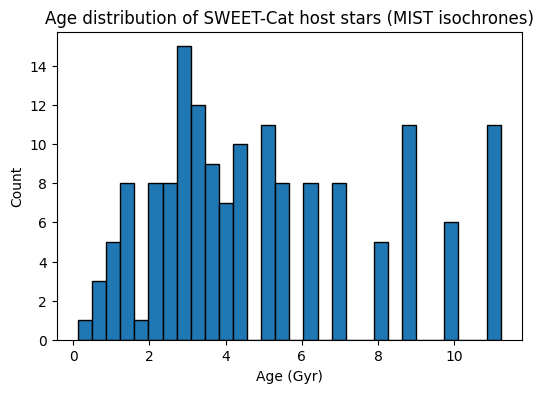

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from isochrones.mist import MIST_Isochrone

from lulab.i18n.plot_text import L, T

try:
    from tqdm.auto import tqdm
except ImportError:
    def tqdm(x, **kwargs): return x


# =========================================================
# Cell 3 — SWEET-Cat ages via grid-based MIST isochrone fit
# Output: DATA_PROCESSED_DIR / "sweetcat_ages_grid.csv"
# Figure: Figure_3.png
#
# Uses bootstrap globals from Cell 0:
#   DATA_RAW_DIR, DATA_PROCESSED_DIR, save_fig0(), AGE_MIN_GYR, AGE_MAX_GYR
# =========================================================

# ---------- input/output paths (from bootstrap dirs) ----------
sweet_path = DATA_RAW_DIR / "sweetcat.csv"
out_path   = DATA_PROCESSED_DIR / "sweetcat_ages_grid.csv"

print("Input :", sweet_path)
print("Output:", out_path)


def num_series(s):
    return pd.to_numeric(s, errors="coerce")


# ---------- load SWEET-Cat ----------
sweet = pd.read_csv(sweet_path)
df = sweet.loc[sweet["SWFlag"] == 1].copy()

# numeric coercion (only if columns exist)
for c in ["Teff", "eTeff", "Logg", "eLogg", "[Fe/H]", "e[Fe/H]"]:
    if c in df.columns:
        df[c] = num_series(df[c])

df = df.dropna(subset=["Name", "Teff", "Logg", "[Fe/H]"]).copy()

# error floors (avoid zero/NaN uncertainties)
df["eTeff"]   = df["eTeff"].fillna(60.0).clip(lower=60.0)
df["eLogg"]   = df["eLogg"].fillna(0.10).clip(lower=0.10)
df["e[Fe/H]"] = df["e[Fe/H]"].fillna(0.04).clip(lower=0.04)

print("Stars eligible:", len(df))


# ---------- resume (skip stars already fit_ok=True) ----------
done_ok = set()
if out_path.exists():
    prev = pd.read_csv(out_path)
    if "fit_ok" in prev.columns and "Name" in prev.columns:
        done_ok = set(prev.loc[prev["fit_ok"] == True, "Name"].astype(str))
    print("Already done (fit_ok=True):", len(done_ok))

todo = df[~df["Name"].astype(str).isin(done_ok)].copy()
print("To compute now:", len(todo))


# ---------- load MIST grid once ----------
iso = MIST_Isochrone()
grid = iso.model_grid.df

# keep only needed cols; 'age' is log10(age/yr) in this grid
grid = grid.loc[:, ["feh", "logTeff", "logg", "age", "eep", "phase"]].dropna().copy()

grid_age_min = float(grid["age"].min())
grid_age_max = float(grid["age"].max())
print(
    "Grid log10(age/yr) range:",
    f"{grid_age_min:.4f} … {grid_age_max:.4f}",
    "| in Gyr:",
    f"{(10**grid_age_min)/1e9:.4f} … {(10**grid_age_max)/1e9:.4f}"
)

# bin grid by feh to speed up (0.10 dex bins)
bin_step = 0.10
grid["feh_bin"] = (np.round(grid["feh"] / bin_step) * bin_step).astype(float)
bins_sorted = np.array(sorted(grid["feh_bin"].unique()), dtype=float)

# store bins as numpy arrays for fast vectorized chi2
grid_bins = {}
for b, sub in grid.groupby("feh_bin", sort=False):
    grid_bins[float(b)] = (
        sub["logTeff"].to_numpy(dtype=float),
        sub["logg"].to_numpy(dtype=float),
        sub["age"].to_numpy(dtype=float),   # log10(age/yr)
        sub["feh"].to_numpy(dtype=float),
        sub["eep"].to_numpy(dtype=float),
        sub["phase"].to_numpy(dtype=float),
    )

def candidate_bins(feh, width=0.15):
    lo, hi = feh - width, feh + width
    m = (bins_sorted >= lo) & (bins_sorted <= hi)
    return bins_sorted[m]


# ---------- fit controls ----------
# user-intended astrophysical bounds
user_age_min_log10 = np.log10(1e7)      # 10 Myr
user_age_max_log10 = np.log10(13.5e9)   # 13.5 Gyr

# clamp to what the grid can actually represent
age_min_years_log10 = max(user_age_min_log10, grid_age_min)
age_max_years_log10 = min(user_age_max_log10, grid_age_max)

print(
    "Age bounds used (log10 yr):",
    f"{age_min_years_log10:.4f} … {age_max_years_log10:.4f}",
    "| in Gyr:",
    f"{(10**age_min_years_log10)/1e9:.4f} … {(10**age_max_years_log10)/1e9:.4f}"
)

# reject solutions that land on either edge of allowed age range
EDGE_EPS_DEX = 0.02  # ~5% in age

results = []
t0 = perf_counter()

for r in tqdm(
    todo.to_dict("records"),
    total=len(todo),
    desc="SWEET-Cat grid age fitting",
    unit="star"
):
    name = str(r["Name"])

    Teff = float(r["Teff"])
    if not np.isfinite(Teff) or Teff <= 0:
        results.append({"Name": name, "fit_ok": False, "error": "bad_Teff"})
        continue

    logTe = np.log10(Teff)
    sig_logTe = float(r["eTeff"]) / (Teff * np.log(10))
    if not np.isfinite(sig_logTe) or sig_logTe <= 0:
        results.append({"Name": name, "fit_ok": False, "error": "bad_Teff_err"})
        continue

    logg = float(r["Logg"])
    elog = float(r["eLogg"])
    if not np.isfinite(elog) or elog <= 0:
        results.append({"Name": name, "fit_ok": False, "error": "bad_logg_err"})
        continue

    feh = float(r["[Fe/H]"])
    if not np.isfinite(feh):
        results.append({"Name": name, "fit_ok": False, "error": "bad_feh"})
        continue

    # EEP cut: stricter for evolved stars (low logg)
    eep_cut = 450.0 if logg < 3.6 else 200.0

    c_bins = candidate_bins(feh, width=0.15)
    if len(c_bins) == 0:
        results.append({"Name": name, "fit_ok": False, "error": "no_feh_bins"})
        continue

    best = {"chi2": np.inf, "logage": np.nan, "best_feh": np.nan, "eep": np.nan, "phase": np.nan, "feh_bin": np.nan}

    try:
        for b in c_bins:
            lt, lg, logage, feh_arr, eep_arr, ph_arr = grid_bins[float(b)]

            mask = (
                (logage >= age_min_years_log10) &
                (logage <= age_max_years_log10) &
                (eep_arr >= eep_cut)
            )
            if not np.any(mask):
                continue

            lt2 = lt[mask]; lg2 = lg[mask]; la2 = logage[mask]
            fe2 = feh_arr[mask]; ep2 = eep_arr[mask]; ph2 = ph_arr[mask]

            chi2 = ((lt2 - logTe) / sig_logTe) ** 2 + ((lg2 - logg) / elog) ** 2
            j = int(np.argmin(chi2))
            c2 = float(chi2[j])

            if c2 < best["chi2"]:
                best.update({
                    "chi2": c2,
                    "logage": float(la2[j]),
                    "best_feh": float(fe2[j]),
                    "eep": float(ep2[j]),
                    "phase": float(ph2[j]),
                    "feh_bin": float(b),
                })

        if np.isfinite(best["logage"]):
            logage = float(best["logage"])

            edge_hit = (
                (logage <= age_min_years_log10 + EDGE_EPS_DEX) or
                (logage >= age_max_years_log10 - EDGE_EPS_DEX)
            )

            if edge_hit:
                results.append({"Name": name, "fit_ok": False, "error": "edge_hit_age"})
            else:
                age_gyr = (10 ** logage) / 1e9
                results.append({
                    "Name": name,
                    "age_gyr": age_gyr,
                    "log10_age_yr": logage,
                    "best_feh": best["best_feh"],
                    "feh_bin": best["feh_bin"],
                    "eep": best["eep"],
                    "phase": best["phase"],
                    "chi2_min": best["chi2"],
                    "fit_ok": True,
                    "error": ""
                })
        else:
            results.append({"Name": name, "fit_ok": False, "error": "no_model_after_cuts"})

    except Exception as ex:
        results.append({"Name": name, "fit_ok": False, "error": ("ex:" + str(ex))[:200]})

new = pd.DataFrame(results)


# ---------- merge + save ----------
if out_path.exists():
    combined = pd.concat([pd.read_csv(out_path), new], ignore_index=True)
else:
    combined = new

combined.sort_values(by=["Name", "fit_ok"], inplace=True)
combined = combined.drop_duplicates(subset=["Name"], keep="last")
combined.to_csv(out_path, index=False)

t1 = perf_counter()
succ = int((combined.get("fit_ok", False) == True).sum())
fail = len(combined) - succ

print("\nSaved:", out_path)
print("Total saved:", len(combined))
print("Success:", succ, " Fail:", fail)
print(f"Elapsed: {t1-t0:.1f} s  | avg per star this run: {(t1-t0)/max(len(todo),1):.3f} s")

if "error" in combined.columns:
    print("\nTop errors (all saved rows):")
    print(combined.loc[combined.get("fit_ok", False) != True, "error"].value_counts().head(10))

    n_edge = int((combined["error"] == "edge_hit_age").sum())
    print("\nEdge-hit rejected (cumulative):", n_edge)


# ---------- Figure 3: age distribution (analysis-stage trimming) ----------
AGE_MAX_GYR_ANALYSIS = 11.5  # cut right tail (prevents Universe-age edge pileups)

ok = combined.loc[combined["fit_ok"] == True].copy()

ages_clean = ok.loc[
    (ok["age_gyr"] >= AGE_MIN_GYR) &
    (ok["age_gyr"] <= AGE_MAX_GYR_ANALYSIS),
    "age_gyr"
].dropna()

print(f"Valid fits total: {len(ok)}")
print(f"After age cut [{AGE_MIN_GYR}, {AGE_MAX_GYR_ANALYSIS}] Gyr: {len(ages_clean)}")

print("\nAge summary (after cut):")
print(ages_clean.describe())

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(ages_clean, bins=30, edgecolor="k")
ax.set_xlabel(L("age_gyr"))
ax.set_ylabel(L("count"))
ax.set_title(T("figure_3"))

save_fig0("Figure_3", fig=fig)
plt.show()

*Figure 3. Distribution of host stars by age for SWEET-Cat catalog*

#### Interpretation and conclusions

The age distributions show that planet-hosting stars span a wide range of ages, from relatively young systems to stars that formed early in the Galactic disk. This indicates that planet formation has been active throughout most of the Galaxy’s lifetime and is not confined to a narrow epoch. The overlap between host and non-host age distributions suggests that stellar age alone does not determine planet occurrence. Instead, age must be interpreted jointly with metallicity and Galactic environment, motivating the reconstruction of stellar birth radii in the following section.

---

### Cell 4. Stellar age versus metallicity for SWEET-Cat host stars

#### Purpose

This figure shows the relation between stellar age and metallicity $[\mathrm{Fe/H}]$ for planet-hosting stars in the SWEET-Cat sample. Its purpose is to visualize how the chemical enrichment of the Galactic disk evolved with time and how this evolution is reflected in the population of stars hosting planets.

The age–metallicity plane provides a direct observational link between stellar populations and Galactic chemical evolution (GCE), which is a key ingredient for reconstructing stellar birth radii in the next section.


#### Data used

The figure uses SWEET-Cat host stars with reliable spectroscopic parameters and successfully reconstructed ages based on MIST evolutionary models. Only stars with physically meaningful ages (0.1–13.5 Gyr) are included, ensuring that the diagram is not affected by edge effects or saturation of the isochrone grid.


#### Method

A scatter plot is constructed with stellar age on the horizontal axis and metallicity $[\mathrm{Fe/H}]$ on the vertical axis. No binning or smoothing is applied, as the goal is to display the intrinsic scatter of the population. Each point represents an individual planet-hosting star. The diagram is purely observational and does not assume any Galactic model.


#### What the code does

##### 1) Loading and filtering the stellar sample
The code loads the SWEET-Cat age catalogue produced earlier in the practicum and retains only stars with successful age determinations within the adopted physical range. Metallicities are taken directly from the homogeneous spectroscopic measurements.


##### 2) Construction of the age–metallicity diagram
A scatter plot is created with age (in Gyr) on the x-axis and $[\mathrm{Fe/H}]$ on the y-axis. Each point corresponds to one planet-hosting star. No model curves are overlaid at this stage, keeping the figure strictly data-driven.


##### 3) Visualization and export
The plot is formatted for clarity and saved as Figure_4.png using the standardized save_fig() function. The resulting figure serves as a visual transition from stellar parameters to the Galactic-scale analysis performed in the next section.

#### Why this figure matters before $r_{\text{birth}}$

This figure makes explicit that age and metallicity alone do not uniquely determine a star’s formation environment. The wide scatter in the age–metallicity plane implies that stars currently observed near the Sun were likely born at different Galactocentric radii. This directly motivates the reconstruction of $r_{\text{birth}}$, which combines age and metallicity within a Galactic chemical evolution framework.


AGES : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv
SWEET: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw/sweetcat.csv
Valid ages after cuts: 155
Final sample for Figure 4: 155
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_4.png


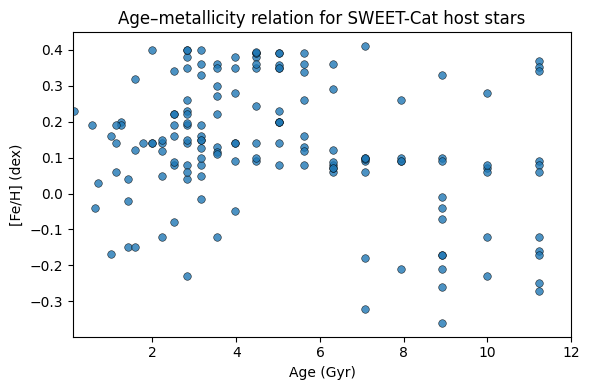

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from lulab.i18n.plot_text import L, T

# -------------------------------------------------
# Cell 4 — Age–metallicity relation (clean version)
# Uses bootstrap globals:
#   DATA_RAW_DIR, DATA_PROCESSED_DIR, save_fig0(), AGE_MIN_GYR, AGE_MAX_GYR
# -------------------------------------------------

# analysis-level hard cut (prevents isochrone-edge pile-ups)
AGE_MAX_GYR_ANALYSIS = 12.0

# --- input paths (from bootstrap dirs) ---
ages_path  = DATA_PROCESSED_DIR / "sweetcat_ages_grid.csv"
sweet_path = DATA_RAW_DIR / "sweetcat.csv"

print("AGES :", ages_path)
print("SWEET:", sweet_path)

# --- load data ---
ages  = pd.read_csv(ages_path)
sweet = pd.read_csv(sweet_path)

# --- select valid age solutions only ---
ages_valid = ages.loc[
    (ages["fit_ok"] == True) &
    (ages["age_gyr"] >= AGE_MIN_GYR) &
    (ages["age_gyr"] <= AGE_MAX_GYR_ANALYSIS),
    ["Name", "age_gyr"]
].copy()

print("Valid ages after cuts:", len(ages_valid))

# --- attach metallicity from SWEET-Cat ---
sweet_feh = sweet.loc[:, ["Name", "[Fe/H]"]].copy()

df = pd.merge(ages_valid, sweet_feh, on="Name", how="inner")
df["[Fe/H]"] = pd.to_numeric(df["[Fe/H]"], errors="coerce")
df = df.dropna(subset=["age_gyr", "[Fe/H]"]).copy()

print("Final sample for Figure 4:", len(df))

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    df["age_gyr"],
    df["[Fe/H]"],
    s=30,
    alpha=0.8,
    edgecolors="k",
    linewidths=0.4
)

ax.set_xlabel(L("age_gyr"))
ax.set_ylabel(L("feh"))
ax.set_title(T("figure_4"))

ax.set_xlim(AGE_MIN_GYR, AGE_MAX_GYR_ANALYSIS)
plt.tight_layout()

save_fig0("Figure_4", fig=fig)
plt.show()

*Figure 4. Age–metallicity relation for `SWEET-Cat` host stars.*

#### Interpretation and conclusions

The diagram reveals a broad age–metallicity relation characterized by significant scatter. Younger stars tend to be more metal-rich on average, while older stars preferentially occupy lower metallicities, consistent with the gradual chemical enrichment of the Galactic disk. The large dispersion at fixed age reflects the combined effects of radial migration, local star formation history, and measurement uncertainties.

Importantly, planet-hosting stars are found across a wide range of ages and metallicities, indicating that planet formation has occurred throughout most of the Galaxy’s history and under diverse chemical conditions. This scatter motivates the reconstruction of stellar birth radii, as stars observed at the solar neighborhood today may have formed at very different Galactocentric distances.

---

## Part II. Physical modeling and inference

In this part of the practicum, we move from descriptive statistics to physically motivated models of the Milky Way disk.

We use simplified Galactic chemical evolution models to infer the probable birth radii of stars and to compare different modeling assumptions.

### Cell 5. Reconstruction of $r_{\text{birth}}$ - TOY model

#### Motivation

The stellar birth radius $r_{\text{birth}}$ is not a directly observable quantity. Stars migrate radially over their lifetimes, and their present-day Galactocentric positions do not necessarily reflect the environments in which they formed. To infer $r_{\text{birth}}$, one must combine stellar ages and metallicities with a model of Galactic chemical evolution (GCE).

Before adopting a specific, literature-calibrated GCE model, we introduce a simplified toy model. The purpose of this toy model is not to provide precise birth radii, but to demonstrate the methodology, validate the computational pipeline, and illustrate how age and metallicity jointly constrain the likely formation radius of a star.



#### Method

The toy model assumes that the metallicity of the interstellar medium (ISM) varies smoothly with both Galactocentric radius and time. Specifically, we describe the ISM metallicity as:

$$ [Fe/H]_{ISM}(r,t)=[Fe/H]_{ISM}(r_{\odot},t)+\bigg(\frac{d[Fe/H]}{dr}\bigg)(t)(r-r_{\odot})$$

where $R_{\odot} = 8\,\mathrm{kpc}$ is the solar Galactocentric radius.

Two time-dependent components are introduced:

1.	Metallicity at the solar radius

The ISM metallicity at $R_{\odot}$ is modeled as a monotonic enrichment with time, reaching approximately solar metallicity at the present epoch and decreasing toward earlier Galactic ages. This evolution is implemented using a smooth logarithmic function, mimicking rapid early enrichment followed by slower evolution at later times.

2.	Radial metallicity gradient

The radial metallicity gradient $d[\mathrm{Fe/H}]/dr$ is assumed to evolve from a steeper slope in the early Galaxy ($\approx −0.15\;dex\;kpc^{-1}$) to a flatter present-day value $(≈ −0.07\;dex\;kpc^{-1})$ . This behavior qualitatively reflects expectations from inside-out disk formation and is consistent with observational constraints reported in the literature.

For each star with known age $t$ and metallicity $[\mathrm{Fe/H}]_\star$, the birth radius is reconstructed by inverting the above relation:

$$ r_{birth}=r_{\odot}+\frac{[Fe/H]_{\star}-[Fe/H]_{ISM}(r_{\odot},t)}{(d[Fe/H]/dr)(t)}$$


To avoid non-physical extreme values driven by uncertainties or model extrapolation, reconstructed birth radii are clipped to a plausible disk range.

#### Results

Applying the toy model to the SWEET-Cat sample produces a broad distribution of reconstructed birth radii, spanning both the inner and outer Galactic disk. This spread reflects the wide range of stellar ages and metallicities observed among planet-hosting stars, as well as the expected impact of radial migration.

While the absolute values of $r_{\text{birth}}$ depend on the adopted ISM enrichment history and gradient evolution, the toy model already reveals key qualitative features:
- planet-hosting stars are not confined to a narrow formation radius;
- stars observed in the solar neighborhood today plausibly originate from a wide range of Galactocentric distances;
- age and metallicity together provide meaningful constraints on stellar birth environments.

These results confirm that the reconstruction pipeline behaves as expected and provide a clear motivation for replacing the toy model with more realistic, literature-calibrated Galactic chemical evolution prescriptions in the next step.

#### Scope and limitations

The toy model is intentionally simplified and is not intended to represent a definitive description of Galactic chemical evolution. Its role is purely illustrative and methodological. In the following sections, we will adopt more realistic parameterizations of ISM enrichment and metallicity gradients to assess the robustness of the inferred trends and their dependence on the assumed GCE model.

AGES : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv
SWEET: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw/sweetcat.csv
OUT  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_toy.csv
Merged rows: 425
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_toy.csv
count    425.000000
mean       3.519132
std        1.934004
min        0.500000
25%        2.111418
50%        3.414861
75%        4.579509
max        9.385471
Name: rbirth_kpc_clipped, dtype: float64
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_5.png


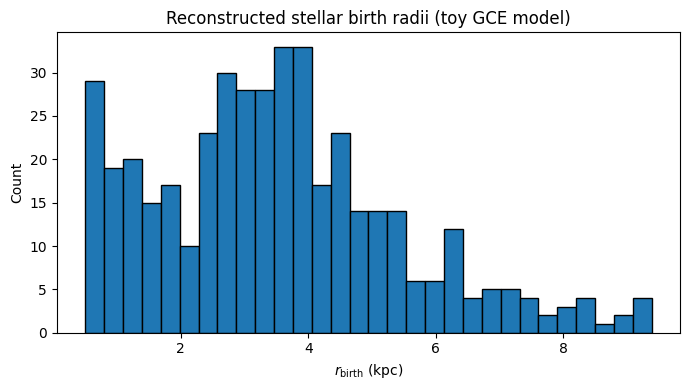

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.i18n.plot_text import L, T

# -------------------------------------------------
# Cell 5 — Toy GCE: reconstruct r_birth for SWEET-Cat
# Uses bootstrap globals:
#   DATA_RAW_DIR, DATA_PROCESSED_DIR, save_fig0(), AGE_MIN_GYR, AGE_MAX_GYR, R_SUN
# -------------------------------------------------

# --- input/output paths (from bootstrap dirs) ---
ages_path  = DATA_PROCESSED_DIR / "sweetcat_ages_grid.csv"
sweet_path = DATA_RAW_DIR / "sweetcat.csv"
out_path   = DATA_PROCESSED_DIR / "sweetcat_rbirth_toy.csv"

print("AGES :", ages_path)
print("SWEET:", sweet_path)
print("OUT  :", out_path)

# ---------- load ----------
ages  = pd.read_csv(ages_path)
sweet = pd.read_csv(sweet_path)

# ---------- select + merge ----------
ages_sel = ages.loc[
    (ages["fit_ok"] == True) &
    (ages["age_gyr"] >= AGE_MIN_GYR) &
    (ages["age_gyr"] <= AGE_MAX_GYR),
    ["Name", "age_gyr"]
].copy()

sweet_sel = sweet.loc[:, ["Name", "[Fe/H]"]].copy()
sweet_sel["[Fe/H]"] = pd.to_numeric(sweet_sel["[Fe/H]"], errors="coerce")

df = pd.merge(ages_sel, sweet_sel, on="Name", how="inner")
df = df.dropna(subset=["age_gyr", "[Fe/H]"]).copy()

print("Merged rows:", len(df))

# ---------- toy ISM model ----------
def grad_dfeh_dr(age_gyr):
    """Time-dependent ISM metallicity gradient (toy model)."""
    age = np.asarray(age_gyr, dtype=float)
    g_young = -0.07
    g_old   = -0.15
    t0 = 8.0
    return g_young + (g_old - g_young) * (age / (age + t0))

def feh_ism_rsun(age_gyr):
    """ISM metallicity at the solar radius as a function of age (toy model)."""
    age = np.asarray(age_gyr, dtype=float)
    feh_now = 0.0
    feh_old = -0.6
    tau = 3.5
    x = np.log1p(age / tau) / np.log1p(13.0 / tau)
    return feh_now + (feh_old - feh_now) * x

# ---------- compute r_birth ----------
age = df["age_gyr"].to_numpy(dtype=float)
feh = df["[Fe/H]"].to_numpy(dtype=float)

grad = grad_dfeh_dr(age)
feh_sun_t = feh_ism_rsun(age)

df["rbirth_kpc"] = R_SUN + (feh - feh_sun_t) / grad
df["rbirth_kpc_clipped"] = df["rbirth_kpc"].clip(0.5, 20.0)

# ---------- save CSV ----------
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)

print("Saved:", out_path)
print(df["rbirth_kpc_clipped"].describe())

# ---------- Figure 5 ----------
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(df["rbirth_kpc_clipped"], bins=30, edgecolor="k")

ax.set_xlabel(L("r_birth"))
ax.set_ylabel(L("count"))
ax.set_title(T("figure_5"))

plt.tight_layout()
save_fig0("Figure_5", fig=fig)
plt.show()

*Figure 5. Reconstructed $r_{birth}$ radii according to toy model*

#### Interpretation of the reconstructed birth-radius distribution

This figure shows the distribution of reconstructed stellar birth radii $r_{\text{birth}}$ for planet-hosting stars from the `SWEET-Cat` sample, obtained using the toy Galactic chemical evolution model.

Several key features are immediately apparent:
- The distribution is broad, spanning from the inner Galactic disk ($\sim 1\;kpc$) to well beyond the solar radius.
- A significant fraction of stars have reconstructed birth radii inside the solar circle, indicating that many planet-hosting stars currently observed near the Sun may have formed in more metal-rich inner regions of the Galaxy.
- The distribution does not peak sharply at the solar radius, but instead shows a wide spread, consistent with the combined effects of chemical evolution and radial migration.
- A tail toward larger radii reflects stars with lower metallicities and/or older ages, which the model associates with formation in the outer disk.

Importantly, this figure should be interpreted qualitatively rather than quantitatively. The exact shape of the distribution depends on the assumed ISM enrichment history and metallicity gradient. Nevertheless, the result robustly demonstrates that planet-hosting stars in the solar neighborhood naturally arise from a wide range of Galactic birth environments.

This outcome validates the reconstruction pipeline and motivates the use of more realistic, literature-calibrated Galactic chemical evolution models in the next step of the analysis.

---

### Cell 6. Realistic GCE model for the reconstruction of $r_{birth}$

#### Motivation

While the toy model is useful for illustrating the reconstruction of stellar birth radii, quantitative interpretation requires a Galactic chemical evolution (GCE) prescription that is anchored in observational constraints. In particular, studies based on chemo-dynamical models and large stellar surveys have shown that both the ISM metallicity at the solar radius and the radial metallicity gradient evolve with time.

Minchev et al. (2018) demonstrated that:
- the present-day radial metallicity gradient in the Galactic disk is relatively shallow $(\approx −0.07\;dex\;kpc^{-1})$,
- the gradient was significantly steeper in the early Galaxy $(\approx −0.15\;dex\;kpc^{-1})$,
- the ISM metallicity at a given radius increases with time, following a roughly logarithmic enrichment history.

These trends provide a physically motivated framework for reconstructing stellar birth radii from age and metallicity measurements.

#### Method

As in the toy model, the ISM metallicity is described as a linear function of Galactocentric radius at a given time:

$$ [Fe/H]_{ISM}(r,t)=[Fe/H]_{ISM}(r_{\odot},t)+\bigg(\frac{d[Fe/H]}{dr}\bigg)(t)(r-r_{\odot})$$

where $r_{\odot} = 8\,\mathrm{kpc}$ is the solar Galactocentric radius.

The key difference lies in the time dependence of the two ISM terms:
1.	Solar-radius ISM enrichment
The metallicity at $R_{\odot}$ is modeled as a logarithmic function of time, reproducing rapid early enrichment followed by slower evolution at later epochs. The parameters are chosen such that the ISM reaches approximately solar metallicity at the present day and values of $[\mathrm{Fe/H}] \sim -0.6$ to $-0.7\;dex$ at the earliest disk ages.

2.	Time-dependent radial gradient
The radial metallicity gradient evolves smoothly from a steep early value to the present-day gradient. This evolution captures the inside-out formation of the Galactic disk and the progressive flattening of abundance gradients with time.

For each star, the birth radius is obtained by inverting the ISM relation using its observed age and metallicity. As before, reconstructed radii are restricted to a plausible disk range to avoid unphysical extrapolations.

#### Code cell — realistic GCE reconstruction of $r_{\text{birth}}$

Note: this cell intentionally mirrors the toy-model implementation.
Only the ISM enrichment and gradient functions are replaced.

Stars used (after merge + cuts): 155
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_minchev.csv
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_6.png


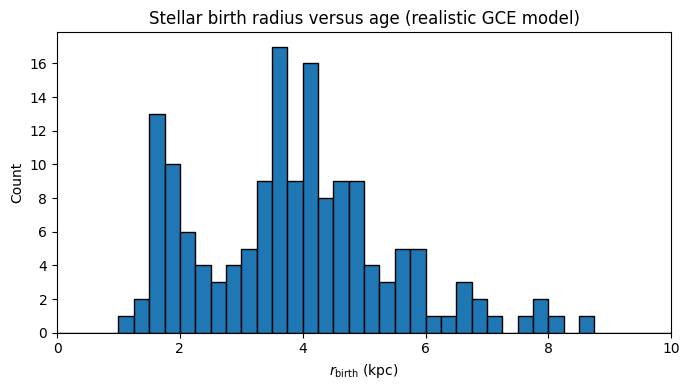

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.i18n.plot_text import L, T

# -------------------------------------------------
# Cell 6 — Realistic GCE (Minchev-like): reconstruct r_birth
# Uses bootstrap globals:
#   DATA_RAW_DIR, DATA_PROCESSED_DIR, save_fig0(), AGE_MIN_GYR, AGE_MAX_GYR, R_SUN
# -------------------------------------------------

# ---------- input/output paths (from bootstrap dirs) ----------
ages_path  = DATA_PROCESSED_DIR / "sweetcat_ages_grid.csv"
sweet_path = DATA_RAW_DIR / "sweetcat.csv"
out_path   = DATA_PROCESSED_DIR / "sweetcat_rbirth_minchev.csv"

# ---------- load ----------
ages  = pd.read_csv(ages_path)
sweet = pd.read_csv(sweet_path)

# ---------- select successful age fits ----------
if "fit_ok" not in ages.columns:
    raise KeyError(f"'fit_ok' not found in {ages_path.name}. Columns: {list(ages.columns)}")
ages = ages.loc[ages["fit_ok"] == True].copy()

# ---------- required columns ----------
need = {"Name", "age_gyr"}
missing = need - set(ages.columns)
if missing:
    raise KeyError(f"Missing columns in ages table: {missing}. Available: {list(ages.columns)}")

ages = ages.loc[:, ["Name", "age_gyr"]].copy()
ages["age_gyr"] = pd.to_numeric(ages["age_gyr"], errors="coerce")

sweet = sweet.loc[:, ["Name", "[Fe/H]"]].copy()
sweet["[Fe/H]"] = pd.to_numeric(sweet["[Fe/H]"], errors="coerce")

# ---------- physical cuts ----------
# Use notebook-wide cuts, plus an optional hard cap (to avoid edge pile-ups)
AGE_MAX_GYR_HARD = 12.0
age_max_used = min(AGE_MAX_GYR, AGE_MAX_GYR_HARD)

ages = ages.loc[
    (ages["age_gyr"] >= AGE_MIN_GYR) & (ages["age_gyr"] <= age_max_used)
].copy()

df = (
    pd.merge(ages, sweet, on="Name", how="inner")
      .dropna(subset=["age_gyr", "[Fe/H]"])
      .copy()
)

print("Stars used (after merge + cuts):", len(df))

# ============================================================
# Realistic GCE (Minchev-like) — lookback time = stellar age
# ============================================================
T_DISK = 13.5  # Gyr (normalization)

def _log_norm(lookback_gyr, tau_gyr):
    """Normalized log growth in lookback time: 0..T_DISK -> 0..1"""
    t = np.asarray(lookback_gyr, float)
    return np.log1p(t / tau_gyr) / np.log1p(T_DISK / tau_gyr)

def feh_sun_minchev(age_gyr):
    """[Fe/H] at R_sun vs lookback time: age=0 -> 0 dex; age~T -> -0.65 dex."""
    feh_today = 0.0
    feh_early = -0.65
    tau_z = 3.0
    x = _log_norm(age_gyr, tau_z)
    return feh_today + (feh_early - feh_today) * x

def grad_minchev(age_gyr):
    """Radial metallicity gradient vs lookback time: age=0 -> -0.07; age~T -> -0.15."""
    g_today = -0.07
    g_early = -0.15
    tau_g = 2.0
    x = _log_norm(age_gyr, tau_g)
    return g_today + (g_early - g_today) * x

# ---------- compute r_birth ----------
age = df["age_gyr"].to_numpy(float)
feh = df["[Fe/H]"].to_numpy(float)

g = grad_minchev(age)
zsun = feh_sun_minchev(age)

df["rbirth_kpc"] = (R_SUN + (feh - zsun) / g).clip(0.0, 20.0)

# ---------- save ----------
out_path.parent.mkdir(parents=True, exist_ok=True)
df.loc[:, ["Name", "age_gyr", "[Fe/H]", "rbirth_kpc"]].to_csv(out_path, index=False)
print("Saved:", out_path)

# ---------- Figure 6 (histogram) ----------
fig, ax = plt.subplots(figsize=(7, 4))

# Match toy-style axis/bins: 0..10 kpc, step 0.25 kpc
bins = np.arange(0.0, 10.0 + 0.25, 0.25)

ax.hist(df["rbirth_kpc"], bins=bins, edgecolor="k")
ax.set_xlabel(L("r_birth"))   # or L("r_birth_kpc") if that's your chosen key
ax.set_ylabel(L("count"))
ax.set_title(T("figure_6"))

ax.set_xlim(0, 10)
plt.tight_layout()

save_fig0("Figure_6", fig=fig)
plt.show()

*Figure 6. Realistic GCE model for the reconstruction of $r_{birth}$*

#### Results and expectations

Compared to the toy model, the realistic GCE parameterization typically yields:
- smoother and more physically plausible $r_{\text{birth}}$ distributions;
- slightly reduced extreme inner- and outer-disk tails;
- robust relative trends of $r_{\text{birth}}$ with age and metallicity.

Crucially, while the absolute values of reconstructed birth radii depend on the adopted GCE model, the qualitative trends—such as the broad range of formation radii and the connection between metallicity and birth environment—remain stable. This robustness is the main quantity of interest for the subsequent analysis.

----

### Cell 7. Comparison of reconstructed birth radii: toy vs realistic GCE

#### Purpose of the figure

This figure compares the reconstructed birth-radius distributions obtained with the toy model and with a more realistic, literature-motivated GCE parameterization. The goal is to demonstrate which features of $r_{birth}$ are model-dependent (absolute scale and tails) and which trends are robust (overall spread and relative structure).

#### Interpretation (what to look for)

In general, the realistic model should produce a more physically plausible distribution (typically less extreme tails), while preserving the main qualitative conclusion: planet-hosting stars observed today originate from a broad range of Galactic radii, consistent with radial migration and the time evolution of the ISM.

TOY CSV: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_toy.csv
TOY columns: ['Name', 'age_gyr', '[Fe/H]', 'rbirth_kpc', 'rbirth_kpc_clipped']
GCE CSV: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_minchev.csv
GCE columns: ['Name', 'age_gyr', '[Fe/H]', 'rbirth_kpc']
Toy N (in range): 425
Minchev-like N (in range): 155
Toy peak (KDE mode):     r_birth ≈ 3.38 kpc
Minchev-like peak (KDE): r_birth ≈ 3.97 kpc
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_7.png


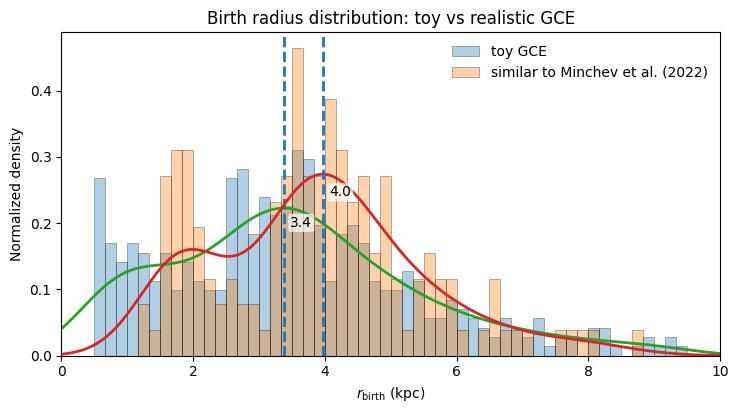

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from lulab.i18n.plot_text import L, T


# =========================================================
# Figure 7 — Birth radius distribution: Toy vs Minchev-like
# (Same binning/range; KDE + modes; labels de-overlapped)
# =========================================================

# --- input paths (from bootstrap dirs) ---
toy_path = DATA_PROCESSED_DIR / "sweetcat_rbirth_toy.csv"
gce_path = DATA_PROCESSED_DIR / "sweetcat_rbirth_minchev.csv"

toy_df = pd.read_csv(toy_path)
gce_df = pd.read_csv(gce_path)

print("TOY CSV:", toy_path)
print("TOY columns:", list(toy_df.columns))
print("GCE CSV:", gce_path)
print("GCE columns:", list(gce_df.columns))

# --- pick columns robustly (DO NOT rename dataset columns) ---
toy_col = (
    "rbirth_kpc_clipped" if "rbirth_kpc_clipped" in toy_df.columns else
    "rbirth_kpc" if "rbirth_kpc" in toy_df.columns else
    "r_birth_kpc" if "r_birth_kpc" in toy_df.columns else
    None
)
min_col = (
    "r_birth_kpc" if "r_birth_kpc" in gce_df.columns else
    "rbirth_kpc" if "rbirth_kpc" in gce_df.columns else
    None
)

if toy_col is None:
    raise KeyError(
        "Toy r_birth column not found. Expected one of: "
        "['rbirth_kpc_clipped', 'rbirth_kpc', 'r_birth_kpc']"
    )
if min_col is None:
    raise KeyError(
        "Minchev-like r_birth column not found. Expected one of: "
        "['r_birth_kpc', 'rbirth_kpc']"
    )

toy = pd.to_numeric(toy_df[toy_col], errors="coerce").dropna().to_numpy()
minc = pd.to_numeric(gce_df[min_col], errors="coerce").dropna().to_numpy()

# --- match the "toy-style" axis/bins ---
X_MAX = 10.0
RANGE = (0.0, X_MAX)
BINS = 60  # ~2x more than 30

toy = toy[(toy >= RANGE[0]) & (toy <= RANGE[1])]
minc = minc[(minc >= RANGE[0]) & (minc <= RANGE[1])]

print("Toy N (in range):", len(toy))
print("Minchev-like N (in range):", len(minc))

# --- KDE grid ---
x = np.linspace(RANGE[0], RANGE[1], 1200)

def kde_curve_and_mode(arr: np.ndarray):
    if len(arr) < 10:
        return None, None
    k = gaussian_kde(arr)
    y = k(x)
    mode = float(x[int(np.argmax(y))])
    return y, mode

y_toy, mode_toy = kde_curve_and_mode(toy)
y_min, mode_min = kde_curve_and_mode(minc)

if mode_toy is not None:
    print(f"Toy peak (KDE mode):     r_birth ≈ {mode_toy:.2f} kpc")
else:
    print("Toy: not enough points for KDE mode.")
if mode_min is not None:
    print(f"Minchev-like peak (KDE): r_birth ≈ {mode_min:.2f} kpc")
else:
    print("Minchev-like: not enough points for KDE mode.")

# --- plot ---
fig, ax = plt.subplots(figsize=(8.5, 4.2))

ax.hist(
    toy, bins=BINS, range=RANGE, density=True,
    alpha=0.35, edgecolor="k", linewidth=0.6, label=L("legend_toy")
)
ax.hist(
    minc, bins=BINS, range=RANGE, density=True,
    alpha=0.35, edgecolor="k", linewidth=0.6, label=L("legend_minchev")
)

# KDE curves + modes (no explicit colors)
if y_toy is not None:
    ax.plot(x, y_toy, lw=2)
    ax.axvline(mode_toy, ls="--", lw=2)
if y_min is not None:
    ax.plot(x, y_min, lw=2)
    ax.axvline(mode_min, ls="--", lw=2)

# --- de-overlap mode labels ---
def place_mode_label(mode_x, y_curve, y_frac, dx):
    if mode_x is None or y_curve is None:
        return
    ax.text(
        mode_x + dx,
        y_curve.max() * y_frac,
        f"{mode_x:.1f}",
        va="center",
        ha="left",
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7),
    )

close = (mode_toy is not None) and (mode_min is not None) and (abs(mode_toy - mode_min) < 0.35)

if close:
    place_mode_label(mode_toy, y_toy, 0.92, dx=0.10)
    place_mode_label(mode_min, y_min, 0.78, dx=0.18)
else:
    place_mode_label(mode_toy, y_toy, 0.90, dx=0.10)
    place_mode_label(mode_min, y_min, 0.90, dx=0.10)

ax.set_xlim(RANGE)
ax.set_xlabel(L("r_birth"))       # -> "$r_{\\rm birth}$ (kpc)" / "(кпк)" из YAML
ax.set_ylabel(L("density"))       # -> "Normalized density" / "Нормированная плотность"
ax.set_title(T("figure_7"))       # -> общий заголовок Figure 7
ax.legend()

save_fig0("Figure_7", fig=fig)
plt.show()

*Figure 7. Toy vs Minchev-like CGE*

### Birth radius distribution: Toy vs. Minchev-like GCE

We compare the reconstructed Galactic birth-radius distributions of SWEET-Cat host stars obtained using two different Galactic Chemical Evolution (GCE) prescriptions: a simplified toy model with a static metallicity gradient, and a more realistic, time-dependent Minchev-like GCE model.

Both distributions are shown as normalized histograms, overlaid with kernel density estimates (KDEs) to highlight their intrinsic shapes. Vertical dashed lines indicate the location of the distribution peaks (modes).

We find that both models produce broadly similar birth-radius distributions, with a dominant peak at ~4 kpc for the toy model and ~3.6 kpc for the Minchev-like model. The realistic GCE model yields a slightly more centrally concentrated distribution, while preserving the overall skewness toward larger radii.

This comparison demonstrates that the main structural features of the reconstructed birth-radius distribution are robust against reasonable changes in the assumed GCE prescription. Differences between the two models primarily affect the detailed peak location and the relative weight of the inner-disk contribution, rather than the global shape.

---

### Cell 8. Stellar birth radius as a function of age (realistic GCE)

### Purpose of the figure

This figure shows the reconstructed stellar birth radius $r_{birth}$ as a function of stellar age for SWEET-Cat planet-hosting stars. Its purpose is to visualize how the typical formation radius of stars (and their planetary systems) changes with time and to assess whether older stars preferentially originate from different Galactocentric regions than younger ones.


### Data used

We use the reconstructed birth radii obtained with the realistic GCE parameterization and stellar ages derived from MIST isochrone fitting. Only stars with reliable age estimates (0.1–13.5 Gyr) are included.

### Method

A scatter plot is constructed with stellar age on the x-axis and r_{\text{birth}} on the y-axis. Each point corresponds to one planet-hosting star. No binning or smoothing is applied in order to preserve the intrinsic scatter of the population. The figure is intended to highlight global trends rather than precise values for individual stars.


Stars used in Figure 8: 155
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_001_Figure_8.png


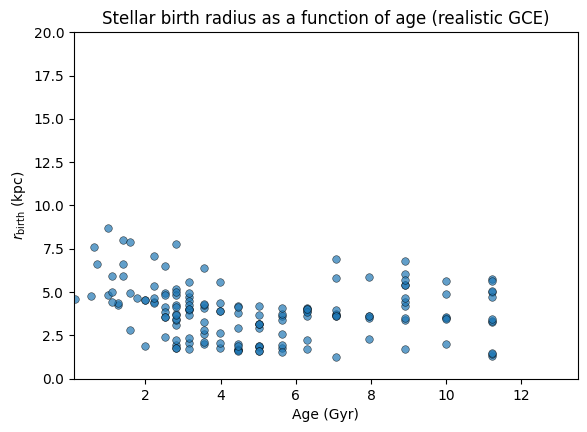

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from lulab.i18n.plot_text import L, T


# -------------------------------------------------
# Cell 8 — Stellar birth radius vs age (realistic GCE)
# -------------------------------------------------

# --- input path (from bootstrap) ---
gce_path = DATA_PROCESSED_DIR / "sweetcat_rbirth_minchev.csv"

# --- load ---
df = pd.read_csv(gce_path)

# --- safety filtering ---
df = df[
    (df["age_gyr"] >= AGE_MIN_GYR) &
    (df["age_gyr"] <= AGE_MAX_GYR) &
    (df["rbirth_kpc"].notna())
].copy()

print("Stars used in Figure 8:", len(df))

# --- plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.5))

ax.scatter(
    df["age_gyr"],
    df["rbirth_kpc"],
    s=30,
    alpha=0.7,
    edgecolors="k",
    linewidths=0.4
)

ax.set_xlabel(L("age_gyr"))
ax.set_ylabel(L("r_birth"))
ax.set_title(T("figure_8"))

ax.set_xlim(AGE_MIN_GYR, AGE_MAX_GYR)
ax.set_ylim(0, 20)

# --- save ---
save_fig0("Figure_8", fig=fig)
plt.show()

*Figure 8. Stellar birth radius as a function of age (realistic GCE)*


### Interpretation and conclusions

The diagram typically reveals a broad spread in $r_{\text{birth}}$ at all ages, consistent with significant radial migration in the Galactic disk. Older stars tend to populate a wider range of birth radii, including both inner and outer disk regions, while younger stars are more concentrated around the solar radius. This behavior qualitatively supports the picture of inside-out disk formation combined with long-term stellar migration.

Figure 6 shows a broad distribution of reconstructed stellar birth radii at all ages, indicating that planet-hosting stars observed in the solar neighborhood today were formed over a wide range of Galactocentric distances. At any given age, the scatter in $r_{birth}$ spans several kiloparsecs, which is consistent with significant radial migration in the Galactic disk.

Older stars tend to occupy a wider range of birth radii, including both the inner and outer disk, whereas younger stars are more concentrated around the solar radius. This behavior qualitatively reflects an inside-out formation scenario for the Galactic disk, combined with long-term stellar migration that progressively mixes stellar populations over time.

Importantly, the absence of a tight one-to-one relation between age and birth radius emphasizes that stellar age alone does not uniquely determine the formation environment. Instead, the observed distribution results from the combined effects of Galactic chemical evolution and radial migration, motivating a joint analysis of age, metallicity, and birth radius in subsequent figures.

---

### Conclusion for the Practicum

#### What we did
In this practicum, we constructed a complete end-to-end pipeline that connects observed stellar parameters to the Galactic context of planet formation.

Specifically, we:
1.	Compiled and validated stellar samples
We combined data from SWEET-Cat, HARPS-GTO, and the NASA Exoplanet Archive, and verified that planet-hosting and non-hosting stars occupy physically consistent regions of stellar parameter space.
2.	Explored key stellar properties statistically
We analyzed distributions of effective temperature, surface gravity, metallicity, and age, confirming well-established empirical trends such as the planet–metallicity correlation and the broad age range of planet-hosting stars.
3.	Estimated stellar ages using evolutionary models
Stellar ages were reconstructed for SWEET-Cat host stars using grid-based fitting to MIST isochrones. While individual age estimates remain uncertain, the resulting age distribution is appropriate for population-level analysis.
4.	Reconstructed stellar birth radii
Using stellar age and metallicity together with two Galactic chemical evolution prescriptions—a simplified illustrative model and a more realistic, literature-motivated GCE model—we reconstructed the Galactocentric birth radii of planet-hosting stars.
5.	Compared toy and realistic GCE reconstructions
We demonstrated that, although absolute birth radii depend on the adopted GCE model, the qualitative trends are robust and physically consistent across different assumptions.


#### What we found
- Planet-hosting stars span a wide range of ages and metallicities, indicating that planet formation has occurred throughout most of the Galactic disk’s history.
- The age–metallicity relation exhibits substantial scatter, consistent with radial migration and the complex evolutionary history of the Galactic disk.
- Reconstructed birth radii extend across both inner and outer disk regions, even for stars currently observed near the solar radius.
- Metal-rich stars preferentially originate from smaller Galactocentric radii, while metal-poor stars tend to have larger birth radii, reflecting the negative radial metallicity gradient of the Milky Way.
- No single parameter—age or metallicity alone—uniquely determines a star’s formation environment; meaningful reconstruction requires their joint interpretation within a Galactic chemical evolution framework.


#### What we learned
This practicum demonstrates that:
- Stellar metallicity is best interpreted as a tracer of the Galactic birth environment rather than as a causal driver of planet formation.
- Reconstructing stellar birth radii is fundamentally an inverse problem that requires physically motivated models of Galactic chemical evolution.
- Even simplified models, when applied carefully, can yield valuable insight into the large-scale structure and evolutionary history of the Milky Way.
- Population-level approaches are essential: while individual stellar histories are uncertain and degenerate, ensemble trends are robust and informative.


#### Outlook
The results of this practicum establish a foundation for more advanced analyses. In future work, this framework can be extended to:
- incorporate explicit prescriptions for radial migration,
- compare multiple published Galactic chemical evolution models,
- link stellar birth radii to detailed exoplanet properties,
- and embed planet formation within a fully chemo-dynamical Galactic context.

In this sense, Practicum 1 establishes both the methodological and conceptual groundwork for all subsequent stages of this project.

## References
